# CM20219 – Image Warping Lab

This lab will explore image warping.
You should download the supporting images from the lab page on the auto-marker, and put them into the same directory as this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Make figures larger.
plt.rcParams['figure.figsize'] = [10, 6]

## Try commenting this out if plots look blurry on your screen.
# %config InlineBackend.figure_format = 'retina'

----
## 1. Forward mapping [25 marks]

Let us start by implementing image warping using forward mapping.
Every pixel in the source image is transformed to the target image independently, leading to gaps between the transformed pixels in the target image.

Feel free to experiment by changing the transformation ‘M’, for example by changing the rotation angle or the scaling transform, or using a random transformation (commented out).

In [3]:
source = plt.imread('mona.jpg') / 255.

## Basic transformations to manipulate the source image.
T = np.array([[1, 0, -source.shape[1] / 2],
              [0, 1, -source.shape[0] / 2],
              [0, 0, 1]])
t = np.pi / 4
R = np.array([[np.cos(t), -np.sin(t), 0],
              [np.sin(t),  np.cos(t), 0],
              [ 0, 0, 1]])
S = np.diag([2, 2, 1])

## The warping transformation (rotation about arbitrary point).
M = np.linalg.inv(T) @ R @ S @ T

# ## The auto-marker tries out random transformations like this.
#M = np.random.rand(3, 3)
#M[:2,2] = 200 * M[:2,2] - 10
#M[2] = 0.001 * M[2]
#M[2,2] = 1
#M = np.linalg.inv(T) @ M @ np.diag(np.random.rand(3)) @ T

a) Implement a function to transform a point (x, y) using a homogeneous 2D transform matrix. [10 marks]

In [4]:
def transform_pixel_nn(x, y, transform):
    """Transforms a source pixel coordinate (x, y) using 'transform', and rounds to the nearest pixel
    coordinate. Returns a tuple (x', y')."""

    ## TASK: Replace this code with your own implementation.
 
    array = np.array([x,y,1])
    
    output = transform @ array
    
    x_d= int(np.round(output[0]/ output[2]))
    y_d = int(np.round(output[1] / output[2]))
    
    return x_d , y_d

b) Implement forward mapping using your per-pixel transform function. [15 marks]

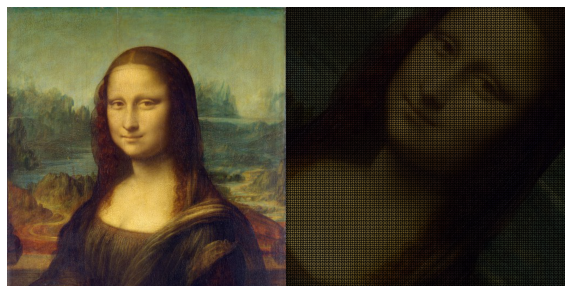

In [5]:
def forward_mapping(source, transform):
    """Warps the 'source' image by the given 'transform' using forward mapping."""

    ## TASK: Replace this code with your own implementation.
    
    source_c = source.copy()
    target_ = np.zeros_like(source)
    

    for y in range(0, target_.shape[0]):
        for x in range(0, target_.shape[1]):
            
           
            q = transform_pixel_nn(x,y, transform)
            
            u = np.round(q[0])
            v = np.round(q[1])
            
            if u > 0 and v > 0 and u < target_.shape[1] and v < target_.shape[0]:
                target_[int(v)][int(u)] = source_c[y][x]
    return target_


## Visualise input (left) and warped output (right).
target = forward_mapping(source, M)
plt.imshow(np.hstack([source, target]))
plt.axis("off");

----
## 2. Backward mapping [15 marks]

Based on your implementation of “forward_mapping”, or otherwise, implement backward mapping using the same 2D transformation ‘M’.
Backward mapping computes for each target image pixel where in the source image it originated, and uses the colour sampled from the nearest pixel.
Note that this should not leave any gaps in the warped image.

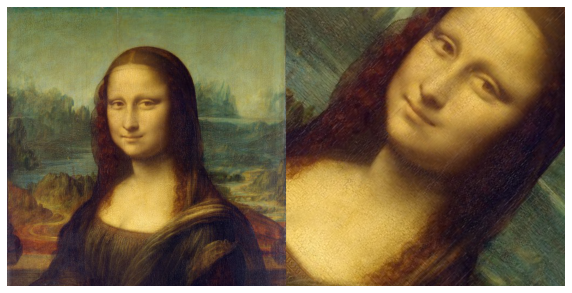

In [6]:
def backward_mapping(source, transform):
    """Warps the 'source' image by the given 'transform' using backward mapping with nearest-neighbour interpolation."""
    
    ## TASK: Replace this code with your own implementation.
    
    source_c = source.copy()
    target_ = np.zeros_like(source)
    
    transform_ = np.linalg.inv(transform)

    for y in range(0, source_c.shape[0]):
        for x in range(0, source_c.shape[1]):
            
            
            q_inv = transform_pixel_nn(x,y , transform_)
            
            sample_x = np.round(q_inv[0])
            sample_y = np.round(q_inv[1])
        
            
            target_[y][x][:] = source_c[int(sample_y)][int(sample_x)][:]
        
    return target_


## Visualise input (left) and warped output (right).
target = backward_mapping(source, M)
plt.imshow(np.hstack([source, target]))
plt.axis("off");

----
## 3. Linear interpolation [20 marks]

a) Extend your backward-mapping function to sample pixel colours from the source image using bilinear interpolation. [15 marks]

b) Handle the edge cases carefully for full marks, i.e. fade to black when sampling pixels on the boundary of the source image. [5 marks]

Hint: It may be helpful to use the commented-out transformations `M`.

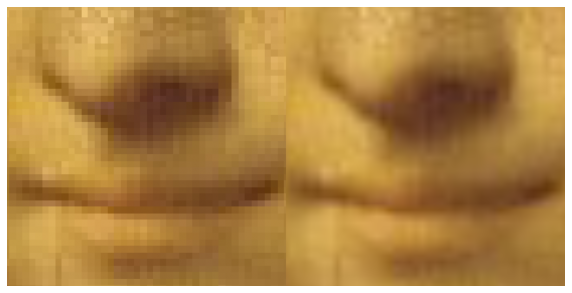

In [7]:
def bi_intp(image_c, x, y, width, height):
    a = x - int(np.floor(x))
    b = y - int(np.floor(y))

    x0 = int(np.floor(x))
    y0 = int(np.floor(y))
    x1 = x0 + 1
    y1 = y0 + 1

    def overborder(x, y):
        if x < 0 or y < 0 or x >= width or y >= height:
            return True
        
        return False

    q11 = q22 = q12 = q21 = 0

    if not overborder(x0, y0):
        q11 = image_c[y0,x0]
    if not overborder(x0, y1):
        q12 = image_c[y1,x0]
    if not overborder(x1, y1):
        q22 = image_c[y1, x1]
    if not overborder(x1, y0):
        q21 = image_c[y0, x1]

    R_1 = ((x1-x) / (x1-x0)) * q11 + ((x-x0) / (x1-x0)) * q21
    R_2 = ((x1-x) / (x1-x0)) * q12 + ((x-x0) / (x1-x0)) * q22

    return ((y1-y) / (y1-y0)) * R_1 + ((y-y0) / (y1-y0)) * R_2
    
    
def backward_mapping_bilinear(source, transform):
    """Warps the 'source' image by the given 'transform' using backward mapping with bilinear interpolation."""
    
    ## TASK: Replace this code with your own implementation.
    
 

    source_c = source.copy()
    
    target_ = np.zeros_like(source)
    
    image_o = forward_mapping(source, transform)
    
    transform_ = np.linalg.inv(transform)

    for y in range(0, image_o.shape[0]):
        for x in range(0, image_o.shape[1]):
            
            
            
            array = np.array([x,y,1])
    
            output = transform_ @ array
    
            x_d= output[0]/ output[2]
            y_d = output[1] / output[2]   
            
            target_[y][x] = bi_intp(source_c, x_d,y_d, target_.shape[1],target_.shape[0])
            
        
    return target_


## Compare nearest-neighbour (left) and bilinear interpolation (right) side by side.
M = np.array([[12, 0, -2486], [0, 12, -2508], [0, 0, 1]])  # big smile
# M = np.array([[40, 0, 80], [0, 40, 80], [0, 0, 1]])  # check edge handling
target_nearest  = backward_mapping(source, M)
target_bilinear = backward_mapping_bilinear(source, M)
plt.imshow(np.hstack([target_nearest, target_bilinear]))
plt.axis("off");

----
## 4. Lens undistortion [40 marks]

This exercise applies a different warping function that is commonly used for removing lens
distortion from images, i.e. to make straight lines straight again.

The polynomial lens distortion model uses the following steps for computing the location $(u', v')$ to sample from the source image for a target image location $(u, v)$:

$$\begin{align}
x &= (u - p_x) / f_x \\
y &= (v - p_y) / f_y \\
r^2 &= x^2 + y^2 \\
x' &= x \cdot (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) \\
y' &= y \cdot (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) \\
u' &= x' \cdot f_x + p_x \\
v' &= y' \cdot f_y + p_y
\end{align}$$

Here, $f_x$ and $f_y$ are the focal lengths of the camera, $(p_x, p_y)$ is called the _principal point_ or _centre of projection_, and $k_1$, $k_2$, $k_3$ are _lens distortion coefficients_.

a) Implement polynomial lens undistortion using the steps above for a single pixel (u, v). [10 marks]

Recall that:
* The `camera_matrix` is defined as $\mathbf{K} = \begin{bmatrix}f_x & 0 & p_x \\ 0 & f_y & p_y \\ 0 & 0 & 1\end{bmatrix}$.
* The lens distortion coefficients `dist_coeffs` are given as $\begin{bmatrix}k_1 & k_2 & k_3\end{bmatrix}$.

In [8]:
def undistort_point(u, v, camera_matrix, dist_coeffs):
    """Undistorts a pixel's coordinates (u, v) using the given camera matrix and
    distortion coefficients. Returns a tuple (u', v')."""

    ## TASK: Replace this code with your own implementation.
    
    
    p_x = camera_matrix[0][2]
    p_y = camera_matrix[1][2]
    f_x = camera_matrix[0][0]
    f_y = camera_matrix[1][1]
    k1 = dist_coeffs[0]
    k2 = dist_coeffs[1]
    k3 = dist_coeffs[2]
    
    
    x = (u - p_x) / f_x
    y = (v - p_y) / f_y
  
    r_squared = np.square(x) + np.square(y)
    
    sum_ = ((1) + (k1*r_squared) + (k2*np.power(r_squared,2)) + (k3* np.power(r_squared,3)))
    
    x_dash = x * sum_
    y_dash = y * sum_
    
    u_dash = x_dash * f_x + p_x
    v_dash = y_dash * f_y + p_y
    
    return u_dash, v_dash



b) Implement polynomial lens undistortion for a given image using your `undistort_point` function above and backward mapping with bilinear interpolation. [10 marks]

In [9]:

def bi_intp(image_c, x, y ,width, height):

    x0 = int(np.floor(x))
    y0 = int(np.floor(y))
    x1 = x0 + 1
    y1 = y0 + 1

    
    def overborder(x, y):
        if x < 0 or y < 0 or x >= width or y >= height:
            return True
        return False

    q11 = q22 = q12 = q21 = 0

    if not overborder(x0, y0):
        q11 = image_c[y0,x0]
    if not overborder(x0, y1):
        q12 = image_c[y1,x0]
    if not overborder(x1, y1):
        q22 = image_c[y1, x1]
    if not overborder(x1, y0):
        q21 = image_c[y0, x1]


    R_1 = ((x1-x) / (x1-x0)) * q11 + ((x-x0) / (x1-x0)) * q21
    R_2 = ((x1-x) / (x1-x0)) * q12 + ((x-x0) / (x1-x0)) * q22

    return ((y1-y) / (y1-y0)) * R_1 + ((y-y0) / (y1-y0)) * R_2

def undistort_image(image, camera_matrix, dist_coeffs):
    """Undistorts an image using the given camera matrix and distortion coefficients."""

    ## TASK: Replace this code with your own implementation.
    
    image_c = image.copy()
    output = np.zeros_like(image)

    
    for y in range(0, output.shape[0]):
        for x in range(0, output.shape[1]):
            q = undistort_point(x,y,camera_matrix, dist_coeffs)
            u = q[0] 
            v = q[1] 
            points = bi_intp(image_c , u , v , image.shape[1] , image.shape[0])
            output[y][x] = points

    return output


## The intrinsic camera matrix and lens undistortion coefficients for the test image.
source = plt.imread('window.jpg') / 255.
camera_matrix = np.array([[474.53, 0, 405.96], [0, 474.53, 217.81], [0, 0, 1]])
dist_coeffs = np.array([-0.27194, 0.11517, -0.029859])


## Visualise input (top) and undistorted output (bottom).
start_time = time.time()
target = undistort_image(source, camera_matrix, dist_coeffs)
print("--- %s seconds ---" % (time.time() - start_time))

plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(np.vstack([source, target]))
plt.axis("off");

NameError: name 'time' is not defined

In [ ]:
def undistort_point_vec(ua, va, camera_matrix, dist_coeffs):
    """Undistorts a pixel's coordinates (u, v) using the given camera matrix and
    distortion coefficients. Returns a tuple (u', v')."""

    ## TASK: Replace this code with your own implementation.
    
    
    p_x = camera_matrix[0][2]
    p_y = camera_matrix[1][2]
    f_x = camera_matrix[0][0]
    f_y = camera_matrix[1][1]
    k1 = dist_coeffs[0]
    k2 = dist_coeffs[1]
    k3 = dist_coeffs[2]
    
    
    x = (ua - p_x) / f_x
    y = (va - p_y) / f_y
    
    r_squared = np.square(x) + np.square(y)
    
    sum_ = ((1) + (k1*r_squared) + (k2*np.power(r_squared,2)) + (k3* np.power(r_squared,3)))
    
    x_dash = x * sum_
    y_dash = y * sum_
    
    u_dash = x_dash * f_x + p_x
    v_dash = y_dash * f_y + p_y
    
    return u_dash, v_dash

In [ ]:
def bi_intp_vec(image_c, xa, ya, width, height):
    
    x0 = np.floor(xa).astype(int)
    y0 = np.floor(ya).astype(int)
    x1 = x0 + 1
    y1 = y0 + 1
    
    q11 = image_c[y0,x0]
    q12 = image_c[y1,x0]
    q22 = image_c[y1, x1]
    q21 = image_c[y0, x1]

    val1 = ((x1-xa) / (x1-x0))[:, None]
    val2 = ((xa-x0) / (x1-x0))[:, None]
    val5 = ((y1-ya) / (y1-y0))[:, None]
    val6 = ((ya-y0) / (y1-y0))[: , None]
    
    return val5 * (val1 * q11 + val2 * q21) + val6 * (val1 * q12 + val2 * q22)

----
c) **Advanced:** Implement fast image undistortion using vectorisation, without any for-loops. Your function should run in less than 3 seconds. [20 marks]

In [ ]:
import time
def undistort_image_vectorised(image,  camera_matrix, dist_coeffs):
    """Undistorts an image using the given camera matrix and distortion coefficients.
    Use vectorised operations to avoid slow for loops."""

    ## TASK: Replace this code with your own implementation.
    
    image_c = image.copy()
    
    xa = np.tile(range(image_c.shape[1]), image_c.shape[0])

    ya = np.repeat(range(image_c.shape[0]), image_c.shape[1])

    xa_dash , ya_dash = undistort_point_vec(xa, ya, camera_matrix, dist_coeffs)

    test = bi_intp_vec(image_c, xa_dash, ya_dash, image_c.shape[1], image_c.shape[0])
    
    output = np.reshape(test, image_c.shape)

    return output

# Visualise input (top) and undistorted output (bottom).

start_time = time.time()

target = undistort_image_vectorised(source, camera_matrix, dist_coeffs)
print("--- %s seconds ---" % (time.time() - start_time))
plt.rcParams['figure.figsize'] = [10, 10]

print(target.shape, source.shape)
plt.imshow(np.vstack([source, target]))
plt.axis("off");